# Data exploration
This notebook contains some tests about data import and some data viz tools

In [65]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Import dataset

In [67]:
# merged_df = generate_clean_df(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE)
merged_df = generate_clean_df_with_kaggle(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE, KAGGLE_FILE)
merged_df.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height,freebase_char/a_map,freebase_char_id,freebase_a_id,a_ethnicity_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780,/m/0jys3m,/m/0bgchn4,/m/0346l4,/m/044038p
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Desolation Williams,Ice Cube,M,African Americans,1969-06-15,32.0,1.727,/m/0jys3g,/m/0bgchn_,/m/01vw26l,/m/0x67
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


# Analyze tvtropes
The goal here is to analyze whether TV tropes dataset can be used in our study or not. 

In [68]:
tropes = pd.read_csv(TROPES_FILE, sep='\t', header=None, names=['trope', 'props'])
tropes.head()

,trope,props
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [69]:
def split_tropes_props(x):
    """
        Split all properties into a column
    """
    res = {'trope': x['trope']}
    res.update(ast.literal_eval(x['props']))
    return res

tropes = tropes.apply(split_tropes_props, axis=1, result_type='expand')
tropes = tropes.rename(columns={'id': 'freebase_char/a_map'})
tropes

,trope,char,movie,freebase_char/a_map,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [70]:
# problem: we only have 501 characters tropes
characters = load_characters(CHARACTERS_FILE)
characters_tropes = pd.merge(left=characters, right=tropes, on='freebase_char/a_map', how='inner')
characters_tropes.head()

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release,freebase_char/a_map,freebase_char_id,freebase_a_id,trope,char,movie,actor
0,196176,/m/01bwgr,1971-11-03,David Sumner,1937-08-08,M,1.66,/m/041rx,Dustin Hoffman,34.0,/m/0k3v65,/m/0ch916z,/m/0bl2g,tranquil_fury,David Sumner,Straw Dogs,Dustin Hoffman
1,1157158,/m/04c13q,2002-03-29,Sheldon Mopes,1969-08-18,M,1.83,NaN,Edward Norton,32.0,/m/0jx3b8,/m/0gy99_8,/m/01515w,granola_person,Sheldon Mopes,Death to Smoochy,Edward Norton
2,504242,/m/02j9_2,2005-08-22,Mr. Universe,1978-05-15,M,1.68,/m/041rx,David Krumholtz,27.0,/m/0k31lb,/m/02sgjdt,/m/05cx7x,playful_hacker,Mr. Universe,Serenity,David Krumholtz
3,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,charmer,Harold Hill,The Music Man,Matthew Broderick
4,6917005,/m/0gwypk,2003-02-16,Harold Hill,1962-03-21,M,1.73,/m/041rx,Matthew Broderick,40.0,/m/04hv61w,/m/09j606t,/m/01vlj1g,loveable_rogue,Harold Hill,The Music Man,Matthew Broderick


In [71]:
# generate profiling report
# profile_movies = ProfileReport(movies, title='Movies report')
# profile_movies.to_file(REPORT_FOLDER + "movies_report_0.html")

# Box office analysis

In [72]:
movies = load_movies(MOVIES_FILE)
movies = clean_unknowns(movies)
movies = clean_jsons(movies)
movies.head()

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [73]:
print("Number of movies with box office revenue indicated: {} ({:.2%})".format(movies.shape[0] - movies['box_office_revenue'].isna().sum(), (movies.shape[0] - movies['box_office_revenue'].isna().sum())/movies.shape[0]))

# keep only movies with box office revenue§
movies_without_na = movies[movies['box_office_revenue'].notna()]
print(movies_without_na.shape)

Number of movies with box office revenue indicated: 8401 (10.28%)
(8401, 9)


In [74]:
# analysis by country

def filter_with_countries(df, target_countries, mode):
    if mode == 'all':
        return df.where(df["countries"].apply(lambda x: all(country in x for country in target_countries))).dropna()
    elif mode == 'any':
        return df.where(df["countries"].apply(lambda x: any(country in x for country in target_countries))).dropna()
    elif mode == 'only':
        return df.where(df["countries"].apply(lambda x: set(x) == set(target_countries))).dropna()
    else:
        raise ValueError('mode must be one of [all, any, only]')

target_countries = ['United States of America']
movies_us = filter_with_countries(movies, target_countries, mode='any')
movies_us.head()

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900.0,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
7,10408933.0,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
17,77856.0,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ..."
21,612710.0,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie..."
29,156558.0,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]"


In [75]:
print("Number of movies from the U.S. with box office revenue indicated:") 
# keep only movies with box office revenue
movies_without_na = movies_us[movies_us['box_office_revenue'].notna()]
print(movies_without_na.shape [0])

Number of movies from the U.S. with box office revenue indicated:
6888


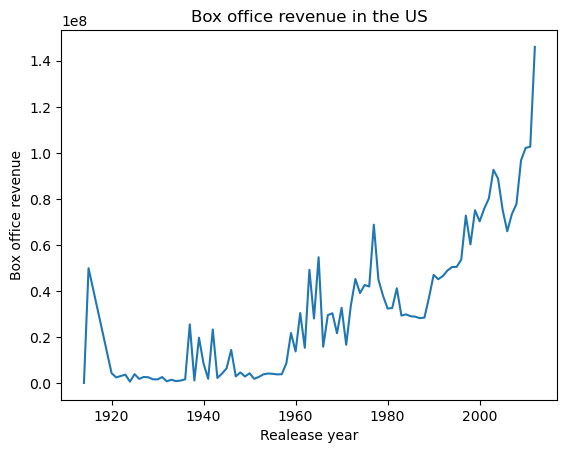

In [76]:
movies_us_year = movies_us.groupby(movies_us['release_date'].dt.year).agg('mean')[['box_office_revenue']]

movies_us_year.plot(legend=False)

plt.title('Box office revenue in the US')
plt.xlabel('Realease year')
plt.ylabel('Box office revenue')
plt.show()

# Import summaries

In [77]:
summaries = pd.read_csv(PLOT_SUMMARIES_FILE, sep='\t', index_col=0, names=['plot'])
summaries.index.name = 'wiki_movie_id'
summaries.head()

,plot
wiki_movie_id,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


## Display most represented ethnicities in movies over the whole dataset

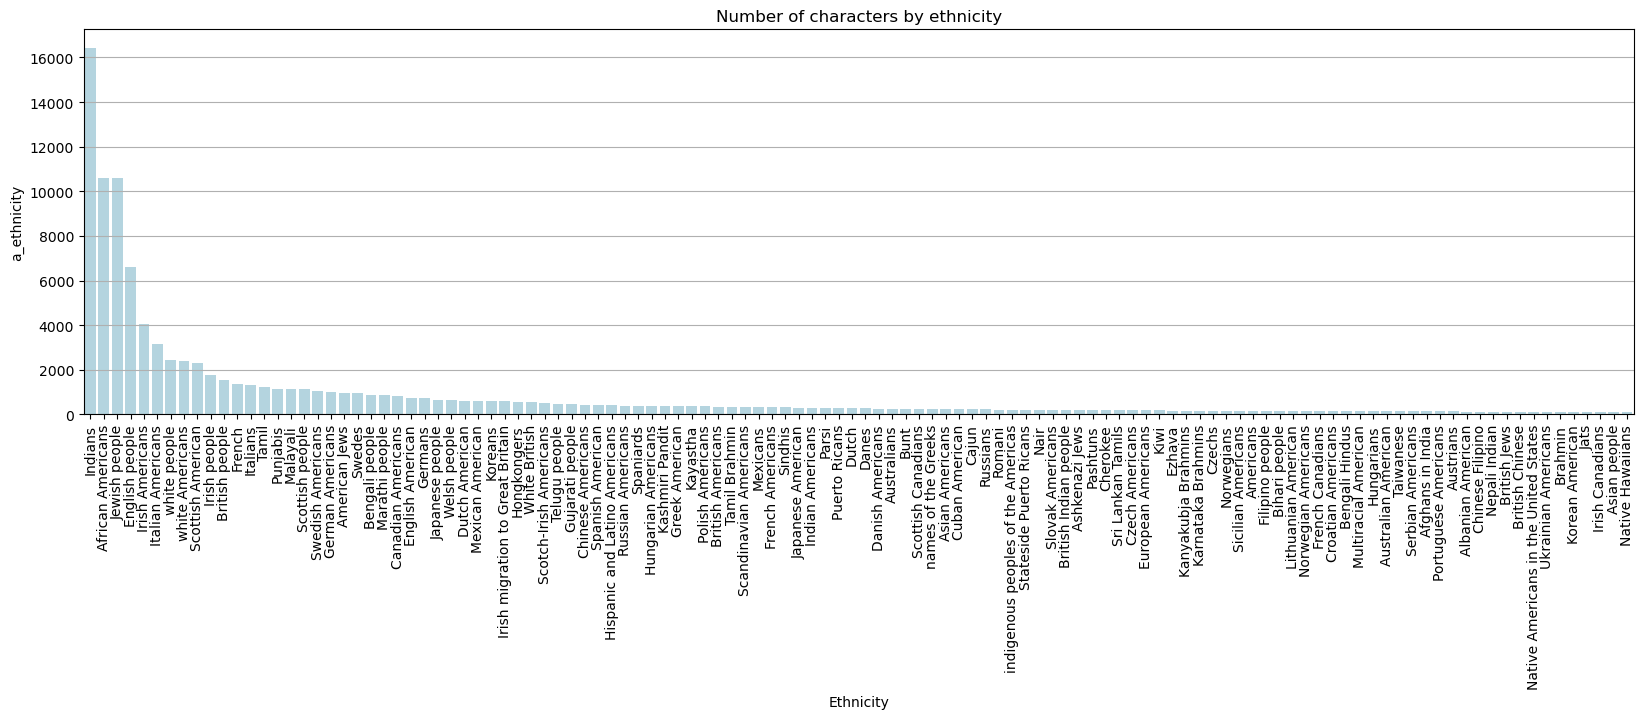

In [78]:
# plot the number of characters of each ethnicity
ethnicity_count = merged_df['a_ethnicity'].value_counts()
ethnicity_count = ethnicity_count[ethnicity_count > 100]

fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Number of characters by ethnicity') 
sns.barplot(x=ethnicity_count.index, y=ethnicity_count, color='lightblue', ax=ax)
# sns.countplot(x=ethnicity_count, color='lightblue', ax=ax)
ax.set_xlabel('Ethnicity')
plt.xticks(rotation=90)
plt.grid(axis='y') #{'major', 'minor', 'both'}
plt.show()

In [79]:
# count instances of ethnicities for each year
char_ethnicity = merged_df[~merged_df['a_ethnicity'].isna()]

# from https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
ethnicity_count = char_ethnicity.groupby([char_ethnicity['release_date'].dt.year // 10 * 10, char_ethnicity['a_ethnicity']]).count()[['wiki_movie_id']]

# gen a "pretty" and usable dataset
ethnicity_count = ethnicity_count.rename(columns={'wiki_movie_id': 'count'})
ethnicity_count = ethnicity_count.reset_index() # level=1
ethnicity_count = ethnicity_count.rename(columns={'release_date': 'm_release_decade'})
ethnicity_count['m_release_decade'] = ethnicity_count['m_release_decade'].astype(int)
ethnicity_count.head()

,m_release_decade,a_ethnicity,count
0,1890,Scotch-Irish Americans,1
1,1890,Scottish people,2
2,1900,Irish Americans,1
3,1900,Irish people,1
4,1900,Jewish people,2


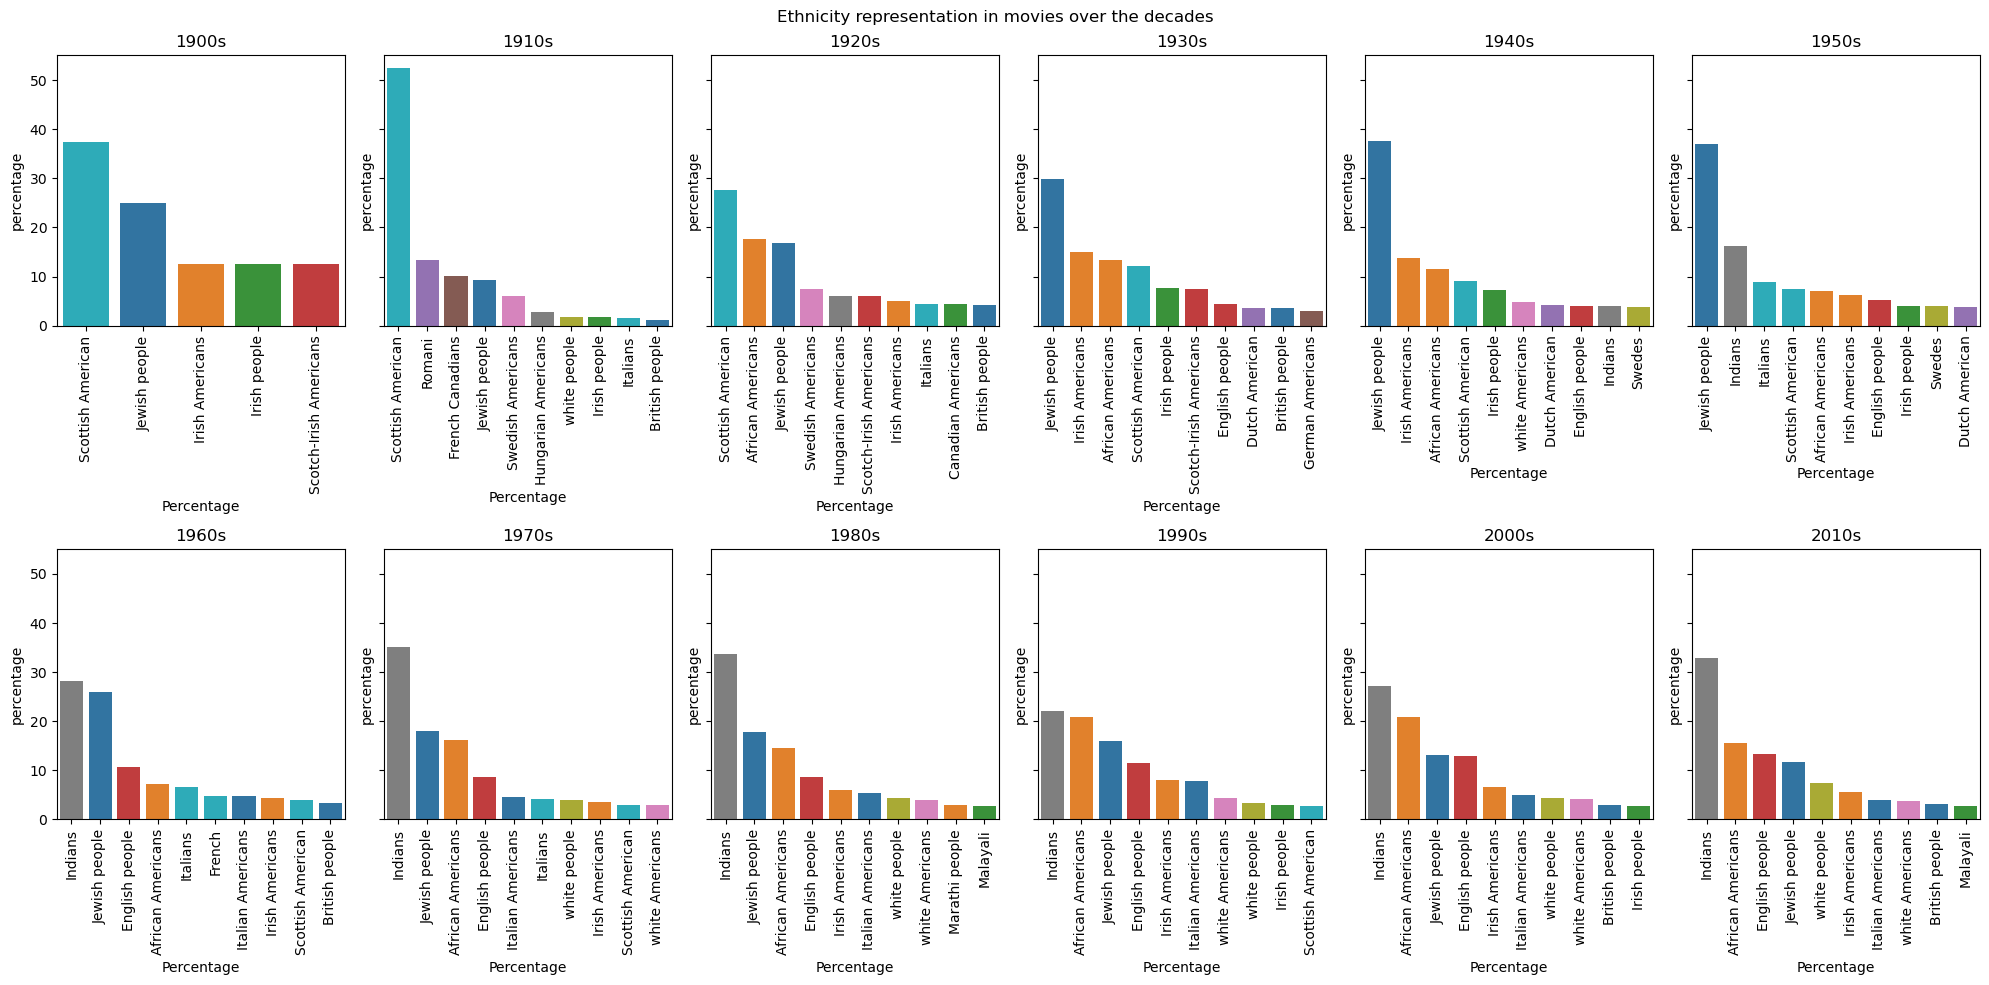

In [80]:
# get k most represented ethnicites for each decade
top_k = 10
decades = ethnicity_count['m_release_decade'].unique()

fig, ax = plt.subplots(2, 6, figsize=(20, 10), sharey=True)
ax = ax.flatten()
colors = {}

for i, decade in enumerate(decades[1:]):
    # get top k ethnicites
    df_top_k = ethnicity_count[ethnicity_count['m_release_decade'] == decade].sort_values(by='count', ascending=False).head(top_k)

    # percentage of the top k
    total = df_top_k['count'].sum()
    df_top_k['percentage'] = df_top_k['count'].apply(lambda x: x / total * 100)
    
    for ethnicity in df_top_k['a_ethnicity'].values:
        if ethnicity not in colors:
            colors[ethnicity] = sns.color_palette(n_colors=40)[len(colors)-1]

    # plot distribution
    sns.barplot(x=df_top_k['a_ethnicity'], y=df_top_k['percentage'], ax=ax[i], palette=[colors[ethnicity] for ethnicity in df_top_k['a_ethnicity'].values])

    ax[i].set_title('{}s'.format(int(decade)))
    ax[i].set_xlabel('Ethnicity')
    ax[i].set_xlabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Ethnicity representation in movies over the decades")
plt.tight_layout()
plt.show()

# Men/women ratio analysis

In [81]:
# At the moment, set the ratio to one if the denominator is zero
def compute_men_women_ratio(x):
    genders = x['a_gender']
    nb_actors = x['a_name'].count()
    nb_male = genders[genders == 'M'].count()
    nb_female = genders[genders == 'F'].count()
    nb_nan_gender = genders.isna().sum()

    nb_known_gender = nb_known_gender=nb_male+nb_female
    m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
    m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
    f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
    nan_ratio = nb_nan_gender / x.shape[0]

    return pd.Series(index=['nb_actors', 'nb_men', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])


df_gender = merged_df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
df_gender['nb_men'] = df_gender['nb_men'].astype(int)
df_gender['nb_female'] = df_gender['nb_female'].astype(int)
df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)
df_gender

,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
wiki_movie_id,,,,,,,,
330,4,0,4,0,0.000000,1.000000,0.000000,0.000000
3217,14,10,3,1,0.769231,0.230769,3.333333,0.071429
3333,28,16,12,0,0.571429,0.428571,1.333333,0.000000
3746,15,11,3,1,0.785714,0.214286,3.666667,0.066667
3837,20,18,2,0,0.900000,0.100000,9.000000,0.000000
...,...,...,...,...,...,...,...,...
37373877,7,3,3,1,0.500000,0.500000,1.000000,0.142857
37476824,10,6,4,0,0.600000,0.400000,1.500000,0.000000
37478048,4,3,1,0,0.750000,0.250000,3.000000,0.000000


In [82]:
# get the info of only one movie
df_gender = pd.merge(left=merged_df[['wiki_movie_id', 'release_date']], right=df_gender, how='inner', left_on='wiki_movie_id', right_index=True)
df_gender = df_gender.drop_duplicates('wiki_movie_id')
df_gender['m_release_decade'] = df_gender['release_date'].dt.year // 10 * 10
df_gender
# df2['m_release_decade'].isna().sum()

,wiki_movie_id,release_date,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio,m_release_decade
0,975900,2001-08-24,17,11,6,0,0.647059,0.352941,1.833333,0.000000,2000.0
17,3196793,2000-02-16,15,11,4,0,0.733333,0.266667,2.750000,0.000000,2000.0
32,28463795,1988-01-01,4,2,2,0,0.500000,0.500000,1.000000,0.000000,1980.0
36,261236,1983-01-01,3,2,1,0,0.666667,0.333333,2.000000,0.000000,1980.0
39,2238856,2005-01-01,15,6,8,1,0.428571,0.571429,0.750000,0.066667,2000.0
...,...,...,...,...,...,...,...,...,...,...,...
467160,7223293,1925-01-01,1,1,0,0,1.000000,0.000000,1.000000,0.000000,1920.0
467161,9971909,1972-09-22,2,2,0,0,1.000000,0.000000,1.000000,0.000000,1970.0
467163,12476867,2002-01-01,8,1,3,4,0.250000,0.750000,0.333333,0.500000,2000.0
467171,913762,1992-05-21,15,10,5,0,0.666667,0.333333,2.000000,0.000000,1990.0


In [83]:
# ratio over the whole dataset
print("Male / Female ratio over the whole dataset:", merged_df[merged_df['a_gender'] == 'M'].shape[0] / merged_df[merged_df['a_gender'] == 'F'].shape[0])
print("Nan ratio over the whole dataset:", merged_df[merged_df['a_gender'].isna()].shape[0] / merged_df.shape[0])

Male / Female ratio over the whole dataset: 2.006941562066152
Nan ratio over the whole dataset: 0.10061238599367708


In [84]:
# mean gender ratio with matching paires
print("Male / Female ratio: :", df_gender['M_F_ratio'].mean())
print("Nan ratio: over bthe whole dataset:", df_gender['nan_ratio'].mean())

Male / Female ratio: : 1.949600329438079
Nan ratio: over bthe whole dataset: 0.08554443944597913


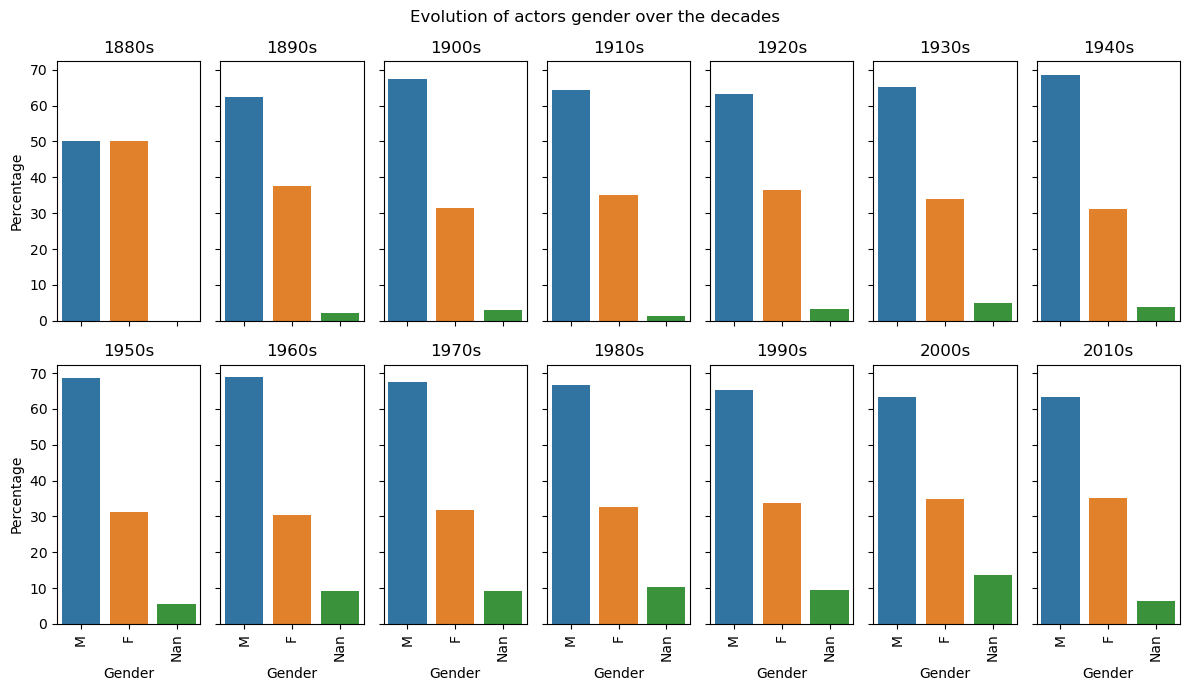

In [85]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 7, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    x = ['M', 'F', 'Nan']
    y = [df_decade['m_ratio'].mean()*100, df_decade['f_ratio'].mean()*100, df_decade['nan_ratio'].mean()*100]

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i])

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Gender')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Evolution of actors gender over the decades")
plt.tight_layout()
plt.show()



In [86]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

gender_dict = {}
for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    gender_dict[decade] = {
        'M': df_decade['m_ratio'].mean()*100,
        'F': df_decade['f_ratio'].mean()*100
        # 'Nan': df_decade['nan_ratio'].mean()*100
        }

gender_ratio_df = pd.DataFrame(gender_dict)
gender_ratio_df.columns = ['{}s'.format(int(col)) for col in gender_ratio_df.columns]
gender_ratio_df = gender_ratio_df.T
gender_ratio_df.head()

,M,F
1880s,50.000000,50.000000
1890s,62.500000,37.500000
1900s,67.352898,31.456625
1910s,64.483401,35.059352
1920s,63.271750,36.377988


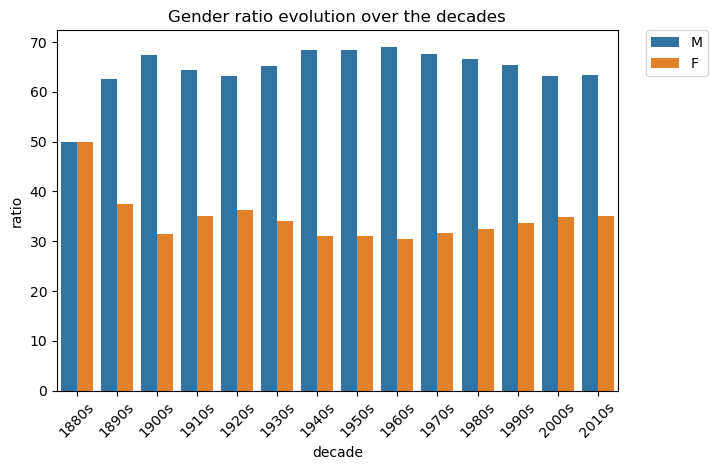

In [87]:
# pivot table to have one row per gender
plot_df = gender_ratio_df.reset_index()
plot_df = plot_df.rename(columns={'index': 'decade'})
plot_df = plot_df.melt(id_vars='decade', value_vars=['M', 'F'])
plot_df = plot_df.rename(columns={'variable': 'gender', 'value': 'ratio'})

# tmp_df
sns.barplot(data=plot_df, x='decade', y='ratio', hue='gender')
plt.title('Gender ratio evolution over the decades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Age analysis

In [88]:
age_df = merged_df.copy()
# here, we suppose that negative ages are just a mistake
age_df['a_age_at_release'] = age_df['a_age_at_release'].abs()
age_df['age_decade_at_release'] = age_df['a_age_at_release'] // 10 * 10
age_df['m_release_decade'] = age_df['release_date'].dt.year // 10 * 10

# age decades
age_decades = age_df['age_decade_at_release'].value_counts().drop([960.0, 7890.0, 930.0]).index
age_decades = np.sort(age_decades)
age_decades

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [89]:
# Here, we put the 70s+ together
age_df['age_decade_at_release'] = age_df['age_decade_at_release'].replace(to_replace=[80.,  90., 100.], value=70.)
age_decades = age_decades[:-3]

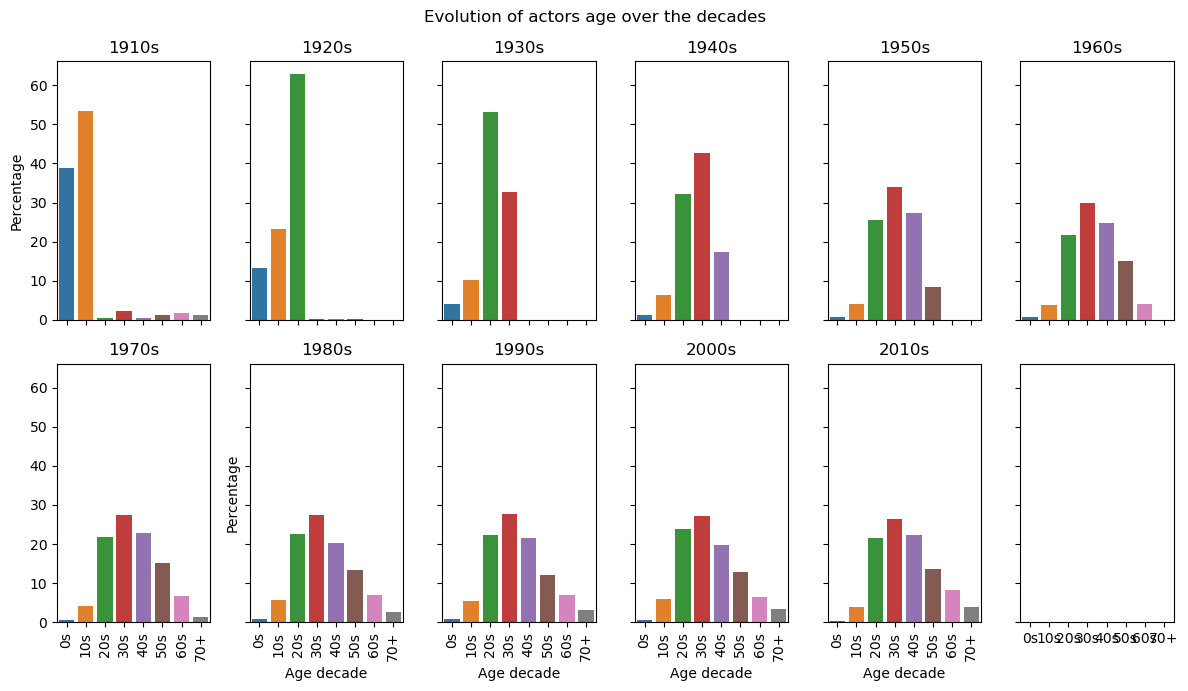

In [90]:
decades = np.sort(age_df['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 6, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]

    x = []
    y = []
    for age_decade in age_decades:
        if age_decade == 70:
            x.append('70+')
        else:
            x.append('{}s'.format(int(age_decade)))
        y.append(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i], palette='tab10')

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Age decade')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

plt.suptitle("Evolution of actors age over the decades")
plt.tight_layout()
plt.show()

In [91]:
age_decades_dict = {}

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]
    
    row = {}
    for age_decade in age_decades:
        if age_decade == 70:
            col_name = '70s+'
        else:
            col_name = '{}s'.format(int(age_decade))

        if col_name in row:
            row[col_name].update(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)
        else:
            row[col_name] =  df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100

    age_decades_dict[decade] = row

In [92]:
# pd.DataFrame(index='decage', columns=['{}s'.format(age_decade) for age_decade in age_decades])
age_decades_df = pd.DataFrame(age_decades_dict)
age_decades_df.columns = ['{}s'.format(int(col)) for col in age_decades_df.columns]
age_decades_df = age_decades_df.T
age_decades_df.columns = ['0-9 y.o.', '10-19 y.o.', '20-29 y.o.', '30-39 y.o.', '40-49 y.o.', '50-59 y.o.', '60-69 y.o.', '70+ y.o.']

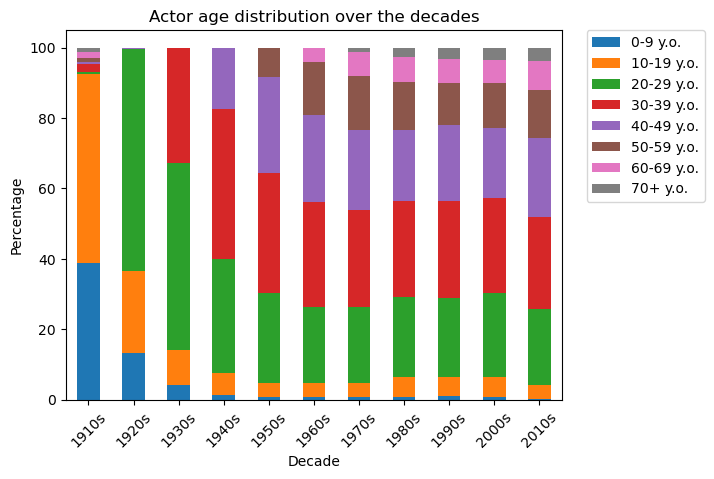

In [93]:
# Potentially interesting: area, bar, pie (but for each of them independently)
# age_decades_df.plot(kind='bar', stacked=True)
age_decades_df.plot(kind='bar', stacked=True)

plt.xticks(rotation=90)
plt.xlabel('Decade')
plt.ylabel('Percentage')
plt.title('Actor age distribution over the decades')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()